### Random Forest

Decision Tree는 과적합되기 쉽다고 알려져 있으며, 이는 예측의 분산을 증가시킨다. Random Forest는 이 문제를 다루고자 더 낮은 분산을 가진 Ensemble 예측을 하도록 설계됐다.

Randon Forest는 데이터 중 Bootstrap된 부분 집합에 대해 개별 추정 모수를 독립적으로 학습해 산출한다는 점에서 Bagging과 비슷하다. Bagging과 비교해 핵심적인 차이는 Random Forest가 2차 수준의 무작위성을 반영한다는 점이다. 각 노드 분할을 최적화할 때 속성의 랜덤 부분 샘플만 평가해서 추정기 간 상관관계를 더욱 축소하려는 목적을 갖고 있다.

Random Forest의 장점은 다음과 같다.

1. Random Forest가 배깅처런 예측 분산을 과적합 없이 줄일 수 있다
2. Random Forest가 feature importance를 계산할 수 있는데, 이는 차후 독립적인 주제로 다룰 예정이다
3. Random Forest는 Out of bag의 정확도를 계산할 수 있다. 그러나 금융에 적용할 시에는 부풀려질 가능성이 있다

배깅에서처럼 Random Forest 또한 개별 Decision Tree보다 반드시 더 낮은 편향을 보이지는 않을 것이다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from FinancialMachineLearning.labeling.labeling import *

triple_barrier_event = pd.read_parquet('../../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../../Data/AAPL_feature_matrix.parquet')

In [2]:
labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)

In [3]:
triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

feature matrix 생성

In [4]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()

In [5]:
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)

In [6]:
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

In [7]:
X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

In [8]:
X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

많은 수의 샘플이 중복되면 여전히 과적합이 발생한다. Bootstrapping은 근본적으로 동일한 tree를 만든다. 여기서 각 decision tree는 과적합된다. Random Forest는 배깅과 달리 항상 bootstrap 샘플을 훈련 데이터셋과 일치하도록 크기를 고정한다. Random Forest 과적합 문제를 `sklearn`에서 다루는 방법을 살펴보자. 예시의 목적으로 `sklearn`의 클래스를 참고한다. 하지만 이 해법은 모든 구현에 적용할 수 있다.

1. parameter `max_features`를 더 낮은 값으로 설정한다. 이는 Tree간의 차이를 발생시키는 방법이다.
2. early stopping : 규제화 parameter `min_weight_fraction_leaf`를 충분히 큰 수 (0.05)로 설정해 OOB의 정확도를 샘플 외 정확도에 수렴하도록 한다.
3. `BaggingClassifier`이 기본 분류기로 `DecisionTreeClassifier`를 사용하면서 `max_samples`는 표본 간의 average uniqueness로 설정한다.

```{python}
weak_model = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 'auto',
    class_weight = 'balanced'
)
bagging = BaggingClassifier(
    base_estimator = weak_model,
    n_estimators = 1000,
    max_samples = average_uniqueness,
    max_features = 1
)
```

4. `BaggingClassifier`의 기본 분류기로 `RandomForestClassifier`를 사용한다. 여기서 `max_features`는 표본 간의 average_uniqueness로 설정한다.
```{python}
forest = RandomForestClassifier(
    n_estimators = 1, 
    criterion = 'entropy',
    bootstrap = False,
    class_weight = 'balanced_subsample'
)

bagging = BaggingClassifier(
    base_estimator = forest,
    n_estimators = 1000,
    max_samples = average_uniqueness,
    max_features = 1
)
```

5. `RandomForestClassifier`의 클래스를 수정해 표준 bootstrapping을 sequential bootstrapping으로 대체한다

아래의 코드는 상이한 클래스를 이용해 Random Forest를 설정하는 세 가지 방법을 보여준다

#### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [10]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

Sequantial Bootstrapping을 적용한 OOB 정확도

In [11]:
forest_fit.oob_score_

0.8315755832534356

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8655126498002663


In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.12      0.07      0.09        70
         1.0       0.91      0.95      0.93       681

    accuracy                           0.87       751
   macro avg       0.52      0.51      0.51       751
weighted avg       0.84      0.87      0.85       751



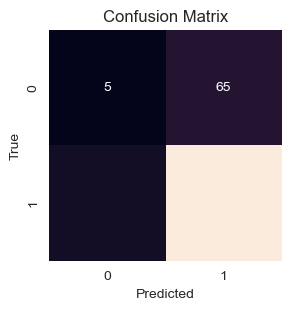

In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

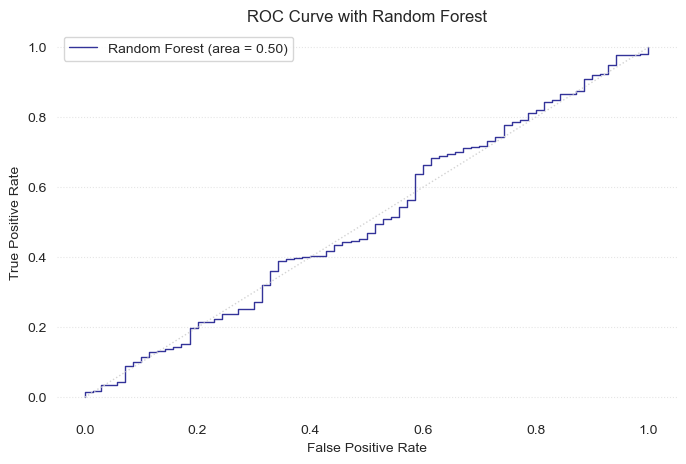

In [15]:
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()

plt.show()

#### Decision Tree & Bagging Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

decision_tree_weak = DecisionTreeClassifier(
    criterion = 'entropy',
    max_features = 3, # early stopping
    class_weight = 'balanced',
    min_weight_fraction_leaf = 0.05 # early stopping
)
tree_bagging = BaggingClassifier(
    estimator = decision_tree_weak,
    n_estimators = 1000,
    max_samples = avg_uniqueness.loc[X_train.index].mean()[0],
    random_state = 42
)

tree_bagging_fit = tree_bagging.fit(
    X = X_train, 
    y = y_train,
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [19]:
y_prob = tree_bagging_fit.predict_proba(X_test)[:, 1]
y_pred = tree_bagging_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9067909454061251


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        70
         1.0       0.91      1.00      0.95       681

    accuracy                           0.91       751
   macro avg       0.45      0.50      0.48       751
weighted avg       0.82      0.91      0.86       751



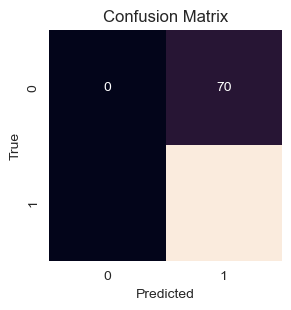

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

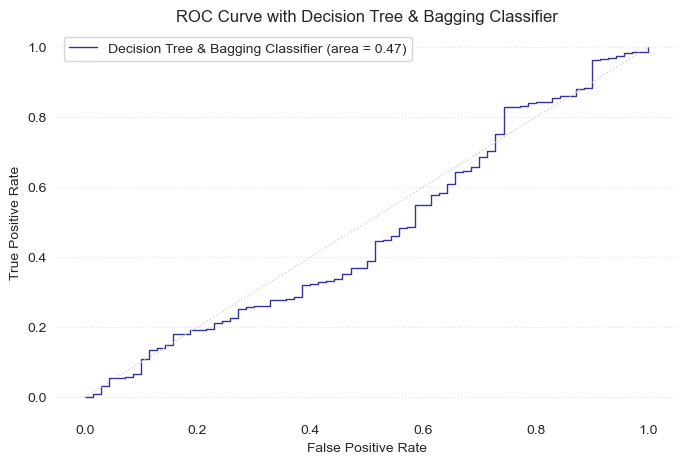

In [22]:
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(fpr, tpr, label = 'Decision Tree & Bagging Classifier (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Decision Tree & Bagging Classifier')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()

plt.show()

#### RandomForest & Bagging Classifier

In [23]:
random_forest_weak = RandomForestClassifier(
    n_estimators = 1,
    criterion = 'entropy',
    bootstrap = False,
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.05,
    max_features = 3,
    random_state = 42
)
forest_bagging = BaggingClassifier(
    estimator = random_forest_weak,
    n_estimators = 1000,
    max_samples = avg_uniqueness.loc[X_train.index].mean()[0],
    max_features = 1,
    random_state = 42
)
forest_bagging_fit = forest_bagging.fit(
    X = X_train, 
    y = y_train,
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [24]:
y_prob = forest_bagging_fit.predict_proba(X_test)[:, 1]
y_pred = forest_bagging_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9067909454061251


In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        70
         1.0       0.91      1.00      0.95       681

    accuracy                           0.91       751
   macro avg       0.45      0.50      0.48       751
weighted avg       0.82      0.91      0.86       751



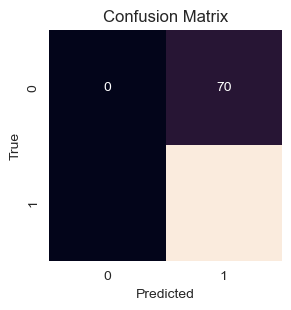

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

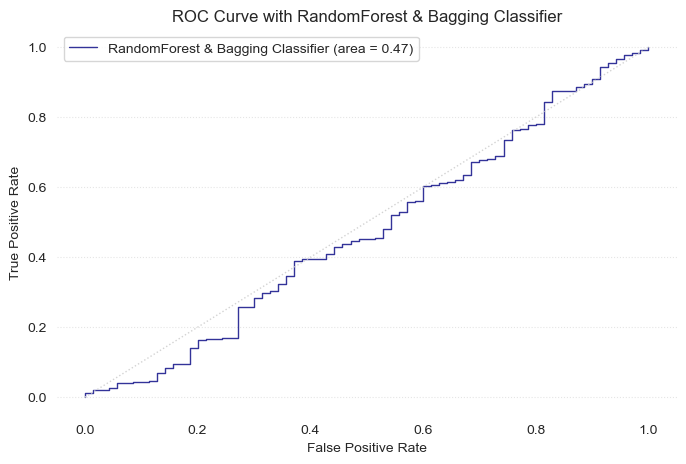

In [27]:
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize = (8, 5))
plt.plot(fpr, tpr, label = 'RandomForest & Bagging Classifier (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
ax.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with RandomForest & Bagging Classifier')

for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
ax.legend()

plt.show()

Decision Tree를 적합화할 때 특성 공간을 축과 일치하는 방향으로 회전하면 Tree에서 필요로 하는 level수를 줄일 수 있다. 이 이유 때문에, PCA features를 Random Forest에 적합화하길 권장한다. 이를 활용해 일부 과적합을 줄이고 계산 속도를 향상시킬 수 있다. 또한, `class_weight = 'balanced_subsample'`로 설정하면 Tree가 소수 클래스를 잘못 분류하는 것을 방지한다